<a href="https://colab.research.google.com/github/lauraluebbert/test_gget_alphafold/blob/main/test_gget_alphafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [gget alphafold](https://github.com/pachterlab/gget) test

___

Install and import gget:

In [1]:
!pip install -U -q gget
import gget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.2/25.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Use Miniconda to install OpenMM:  

In [2]:
# For pretty plots
%config InlineBackend.figure_format='retina'

# Install Miniconda
import sys
!rm -rf /opt/conda
!wget -q -P /tmp \
  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
    && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
    && rm /tmp/Miniconda3-latest-Linux-x86_64.sh

# Install openmm v7.7.0
PATH=%env PATH
%env PATH=/opt/conda/bin:{PATH}
!conda install -qy conda==4.13.0 \
    && conda install -qy -c conda-forge \
      python=3.10 \
      openmm=7.7.0

# Add to path
sys.path.append('/opt/conda/lib/python3.10/site-packages')

PREFIX=/opt/conda
Unpacking payload ...
                                                                                    
Installing base environment...





Preparing transaction: - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /opt/conda
env: PATH=/opt/conda/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environ

Install third-part dependencies and download AlphaFold model parameters using `gget setup` (this might take a few minutes):

In [3]:
gget.setup("alphafold")

######################################################################## 100.0%


Predict the 3D structure of CASP14 target [T1024](https://predictioncenter.org/casp14/target.cgi?id=8&view=all):

Jackhmmer search: 100%|██████████| 199/199 [elapsed: 20:53 remaining: 00:00]



230 unique sequences found in total for sequence 1



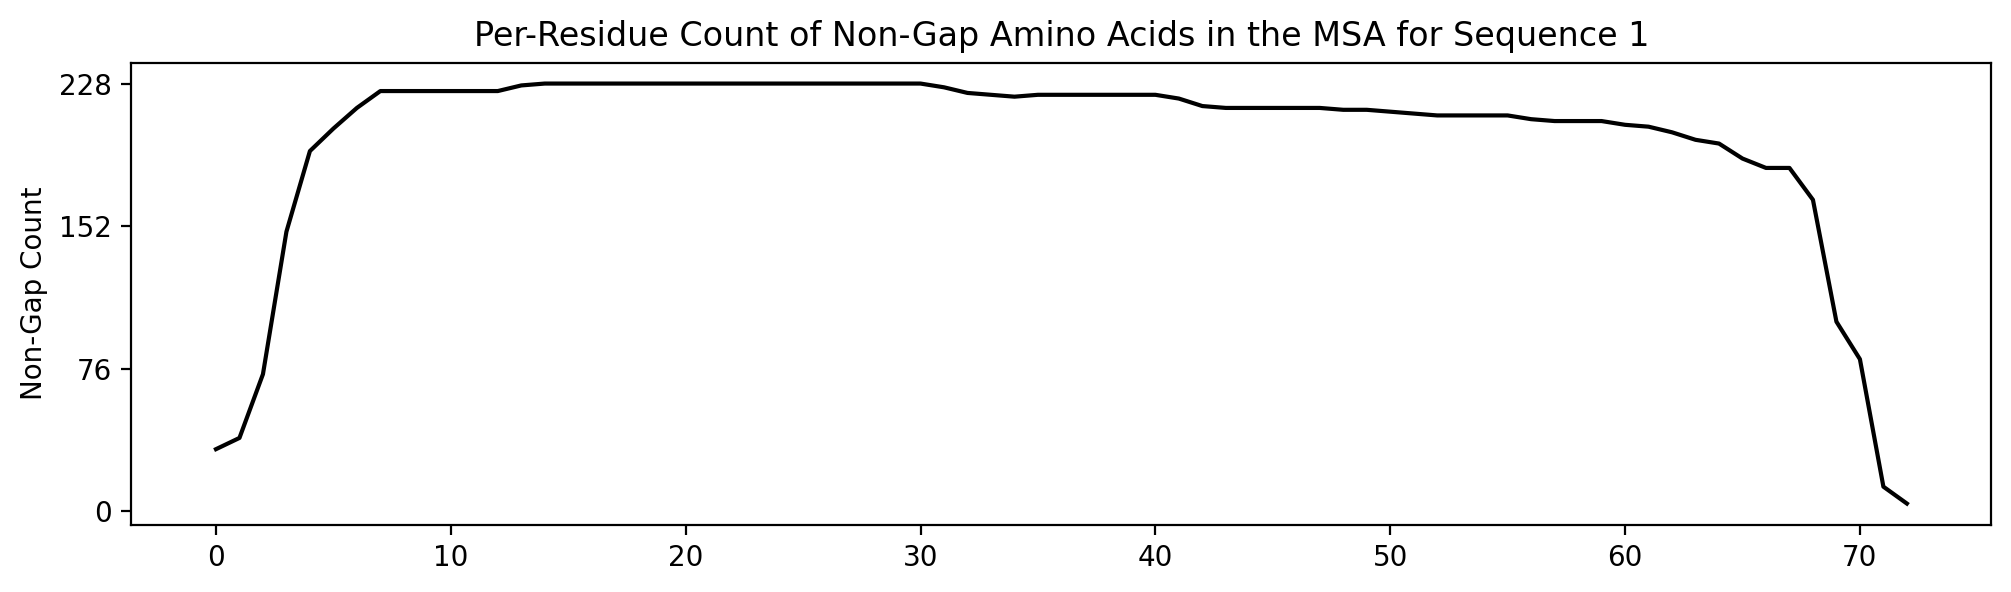

AMBER relaxation: 100%|██████████| 7/7 [elapsed: 12:12 remaining: 00:00]


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

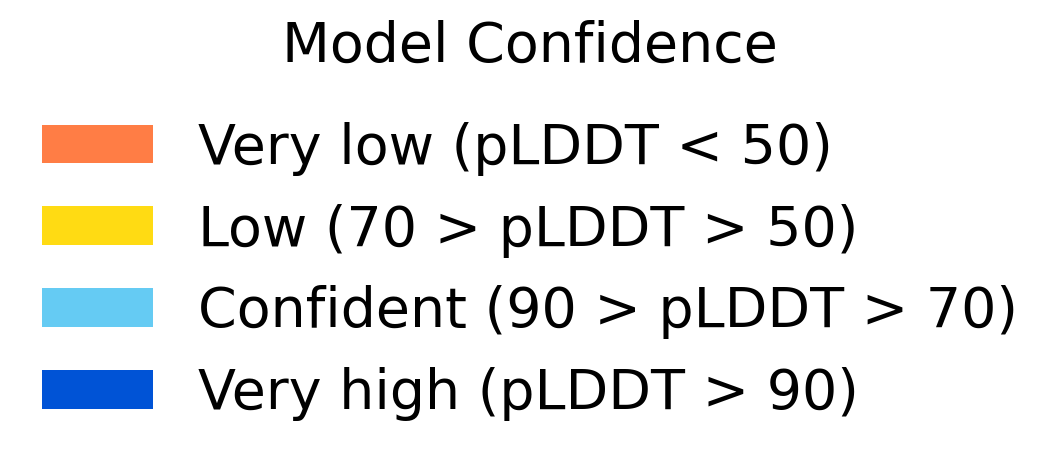

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

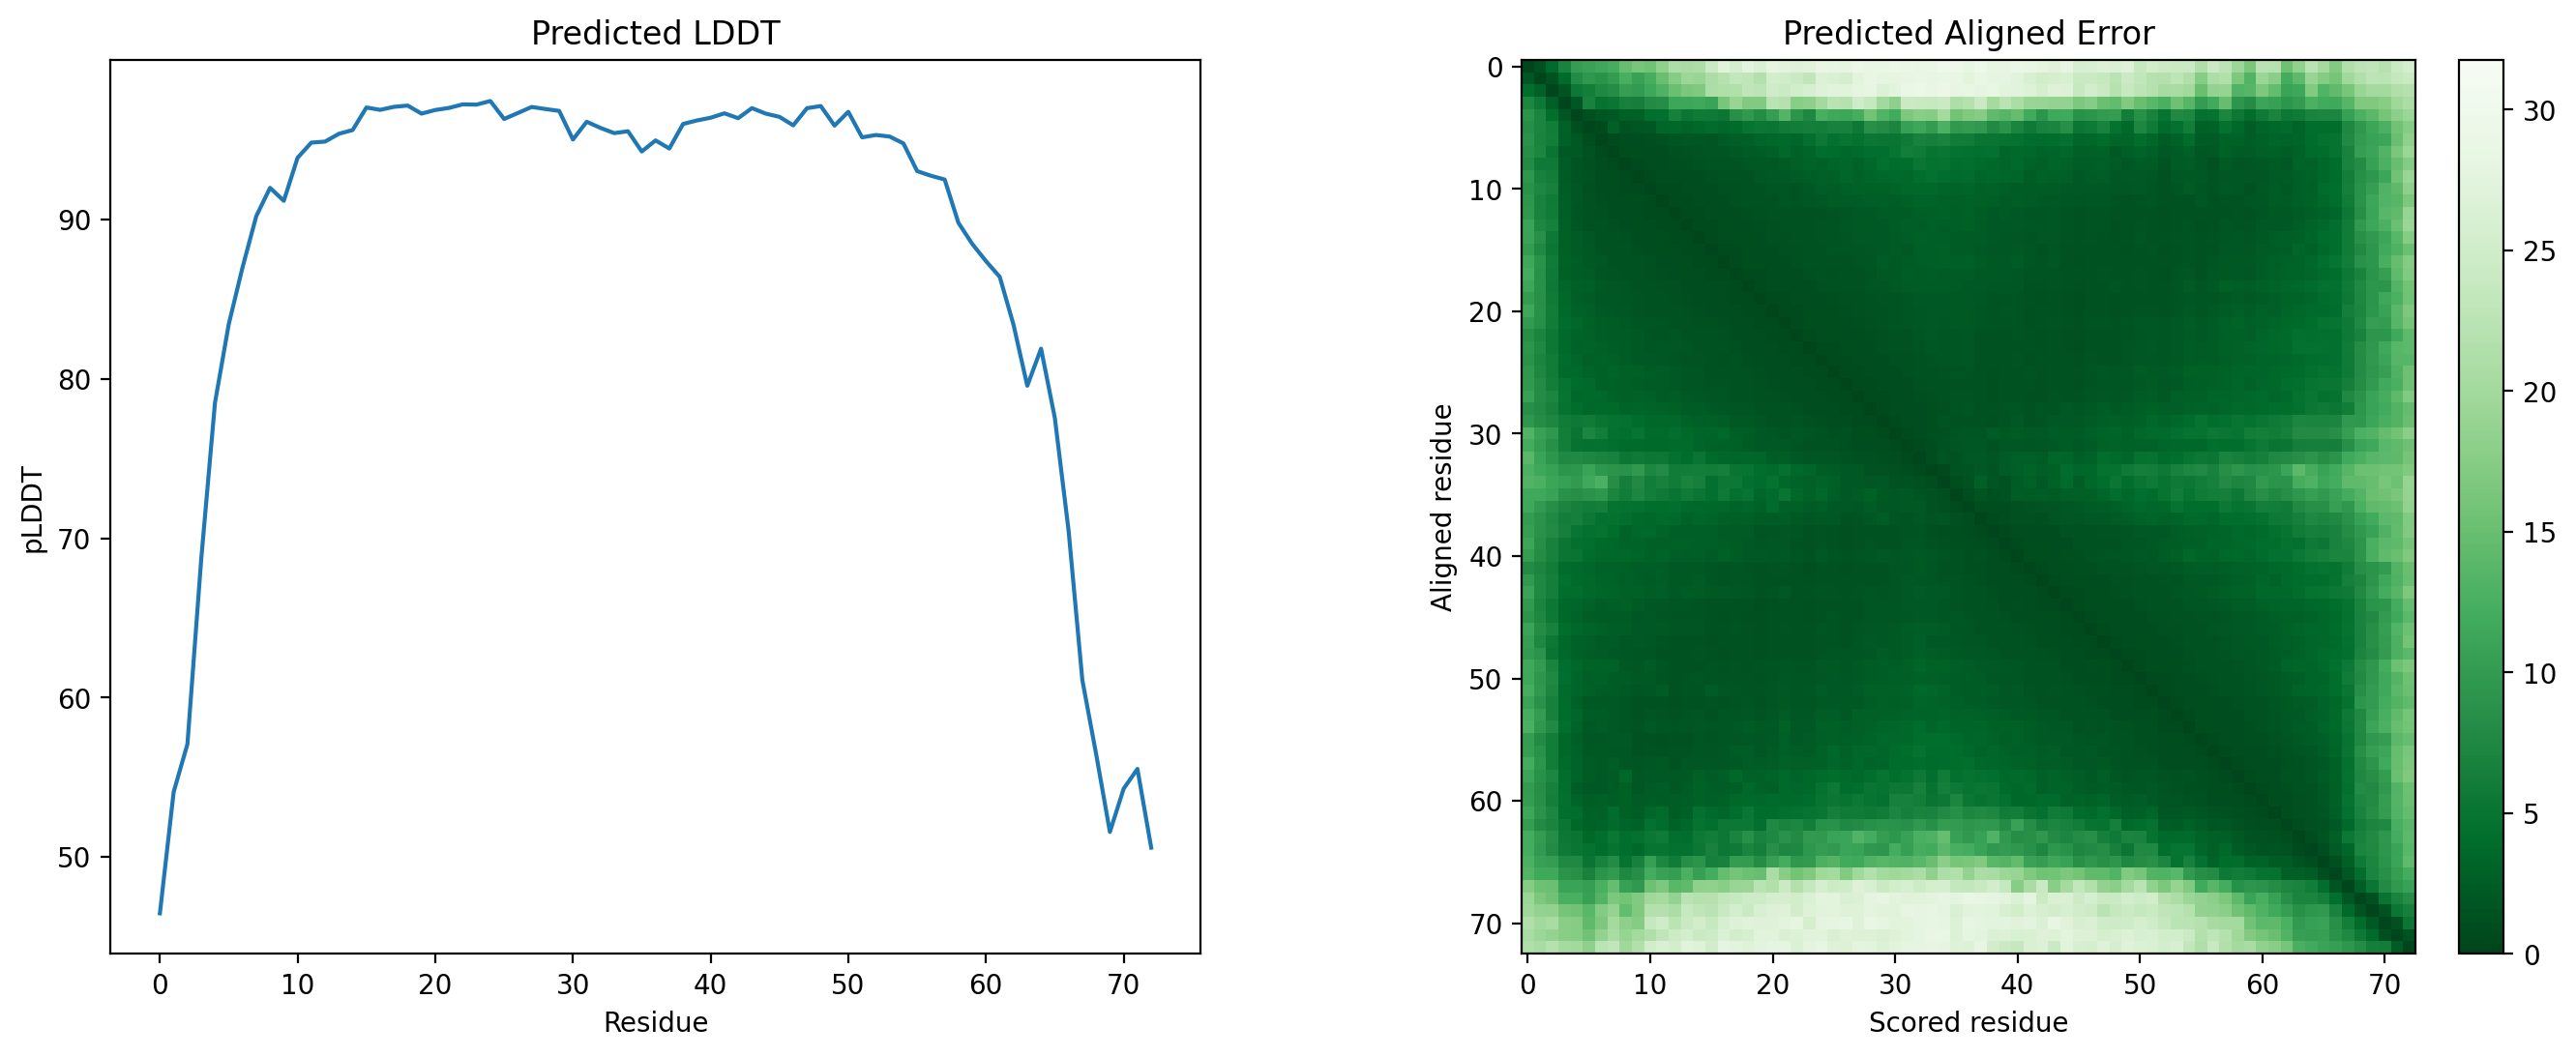

In [4]:
gget.alphafold(
    "MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH", 
    relax=True, 
    out=None
    )